Convert amplitude spectrum exported from OpendTect into a constant phase wavelet

In [9]:
import numpy as np
import matplotlib.pyplot as plt

#Input amplitude spectrum
seisfile="qsi_stack_amp_spectrum.dat"

#Shape parameter for Kaiser window
beta=20

#Number of samples of the operator
num=70

#Output operator file
operatorfile="qsi_stack_cp_wavelet.dat"

In [10]:
#Load exported spectrums from OpendTect
freqseis, ampseis=np.loadtxt(seisfile, unpack=True)

# dB to amplitude conversion
ampseis=np.power(10,ampseis/20)

In [11]:
#Normalize seismic spectrum
normseis = ampseis / np.max(ampseis)

#Calculate dt
dt=1/(2*np.max(freqseis))

#Setup complex amplitude spectrum for ifft with phase assumption
phase=np.radians(0)
cspectrum_poz=normseis*(np.cos(phase)+1j*np.sin(phase))
cspectrum_neg=normseis*(np.cos(-1*phase)+1j*np.sin(-1*phase))
rev_cspectrum_neg=np.fliplr([cspectrum_neg])[0]
input_cspectrum=np.append(cspectrum_poz,rev_cspectrum_neg)

#Calculate ifft and reorder arrays
t_op=np.fft.ifft(input_cspectrum)
start_t=((-1/2)*dt*(len(input_cspectrum)))+dt
t_shift=np.linspace(start_t,-1*start_t,len(t_op))-dt/2
t_op_shift=np.fft.ifftshift(t_op)

#Tapering of the time domain wavelet using a Kaiser window, 
# and calculation of the operator triming indexes, and plot the final operator

#Tapering
window_kaiser=np.kaiser(len(t_shift),beta)

t_op_final=t_op_shift*window_kaiser

#Operator trimming indexes
start_i=(int(len(t_shift)/2))-int(num/2)
stop_i=((int(len(t_shift)/2))+int(num/2))+1

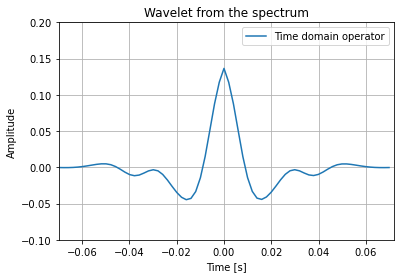

In [12]:
#Plot final time domain operator
plt.figure(1)
plt.title('Wavelet from the spectrum')
plt.plot(t_shift[start_i:stop_i],t_op_final[start_i:stop_i].real, label='Time domain operator')
plt.xlim(t_shift[start_i],t_shift[stop_i])
plt.ylim(-0.1,0.2)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

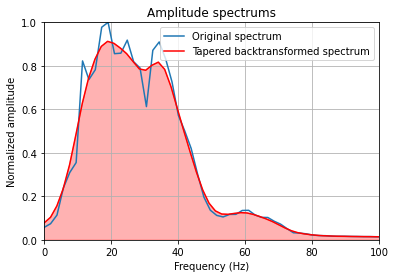

Wavelet is saved to: qsi_stack_cp_wavelet.dat


In [13]:
#Save final operator
np.savetxt(operatorfile,t_op_final[start_i:stop_i].real)

#QC operator by transform tapered operator to frequency domain
bt_op=np.fft.fft(t_op_final)
backfreq=np.fft.fftfreq(len(t_op_final),dt)

#Keeping only the positive frequencies
backfreq_poz=backfreq[:int(len(backfreq)/2)]
bt_op_poz=bt_op[:int(len(bt_op)/2)]

plt.figure(2)
plt.title('Amplitude spectrums')
plt.plot(freqseis, normseis,label='Original spectrum')
plt.plot(backfreq_poz,abs(bt_op_poz), label='Tapered backtransformed spectrum', color='red')
plt.fill_between(backfreq_poz, abs(bt_op_poz),0, abs(bt_op_poz) > 0.0, interpolate=False, color='red', alpha = 0.3)
plt.ylabel('Normalized amplitude')
plt.xlabel('Frequency (Hz)')
plt.xlim(0,100)
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.show()
print('Wavelet is saved to:',operatorfile)